# Machine learning - Features extraction

Runs binary and multi-class classifiers on a given dataset.
Dataset are read as Parquet file. The dataset must contain a feature vector named "features" and a classification column.

## Imports

In [1]:
import pandas as pd
import mltoolkit
from pyspark.sql import SparkSession
import numpy as np
import sklearn

## Configure Spark Session

In [2]:
spark = SparkSession.builder \
                    .master("local[*]") \
                    .appName("datasetClassifier") \
                    .getOrCreate()

## Read in data from parquet file

In [3]:
parquetFile = './intput_features/'
data = spark.read.parquet(parquetFile).cache()

df = data.toPandas()
print(f"Total number of data: {df.shape[0]}")
df.head()

Total number of data: 9567


,structureChainId,alpha,beta,coil,foldType,features
0,1RXQ.D,0.662722,0.065089,0.272189,other,"[0.5052433708514281, 0.39907651862371607, -0.3..."
1,1RYL.B,0.550336,0.154362,0.295302,alpha+beta,"[0.2862339211538075, 0.3137033899168832, -0.03..."
2,1RYO.A,0.367284,0.212963,0.419753,alpha+beta,"[0.29367011161578216, 0.35279737824311286, -0...."
3,1RZ3.A,0.423913,0.228261,0.347826,alpha+beta,"[0.271732849823311, 0.30806871705222877, -0.09..."
4,1RZ4.A,0.676056,0.028169,0.295775,alpha,"[0.3562608102709055, 0.5141948204528954, -0.28..."


## Select only alpha and beta foldType

In [4]:
df = df[(df.foldType == 'alpha') | (df.foldType == 'beta')]

print(f"Total number of data: {df.shape[0]}")
df.head()

Total number of data: 2390


,structureChainId,alpha,beta,coil,foldType,features
4,1RZ4.A,0.676056,0.028169,0.295775,alpha,"[0.3562608102709055, 0.5141948204528954, -0.28..."
5,1RZH.L,0.619217,0.035587,0.345196,alpha,"[0.12472582102221037, 0.08776423343058143, -0...."
6,1RZH.M,0.634551,0.039867,0.325581,alpha,"[0.1600593357754786, 0.1681052131085273, -0.18..."
8,1S0P.B,0.755682,0.011364,0.232955,alpha,"[0.3622322499432734, 0.47637778217771226, -0.1..."
13,1S2X.A,0.772222,0.000000,0.227778,alpha,"[0.32439254217031527, 0.4800257507938801, 0.05..."


## Basic dataset information and setting

In [5]:
label = 'foldType'
testFraction = 0.1
seed = 123


vector = df.features.iloc[0]
featureCount = len(vector)
print(f"Feature count    : {featureCount}")

 
classCount = df.foldType.unique().size
print(f"Class count    : {classCount}\n")

  
print(f"Dataset size (unbalanced)    : {df.shape[0]}")
print(df.foldType.value_counts())


df = mltoolkit.downsample(df, 'foldType')
print(f"\nDataset size (balanced)  : {df.shape[0]}")
print(df.foldType.value_counts())

Feature count    : 50
Class count    : 2

Dataset size (unbalanced)    : 2390
alpha    1764
beta      626
Name: foldType, dtype: int64

Dataset size (balanced)  : 1252
beta     626
alpha    626
Name: foldType, dtype: int64


## Random Forest Classifier


 Class	Train	Test

alpha	556	70

beta	570	56

Total time taken: 0.08280205726623535

Methods	RandomForestClassifier
AUC	0.8910714285714286
F Score	0.7966101694915255
Accuracy	0.8095238095238095
Precision	0.7580645161290323
Recall	0.8392857142857143
False Positive Rate	0.24193548387096775
True Positive Rate	0.859375
	
Confusion Matrix
['alpha' 'beta']
[[55 15]
 [ 9 47]]


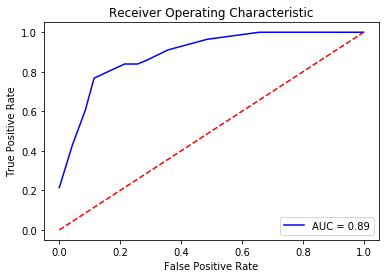

Sample predictions: 


,index,structureChainId,alpha,beta,coil,foldType,features,indexedLabel,predictions
0,6647,3LDC.A,0.780488,0.000000,0.219512,alpha,"[0.4148281691940846, 0.12487881593866113, -0.3...",0,beta
1,6695,4ESK.B,0.031250,0.572917,0.395833,beta,"[0.5170213629740594, 0.63140712519831, -0.1713...",1,beta
2,1040,1XQO.A,0.640316,0.000000,0.359684,alpha,"[0.3591176809268255, 0.3501471270679259, -0.00...",0,alpha
3,3830,4MYZ.B,0.653846,0.000000,0.346154,alpha,"[0.5587056702337204, 0.7814326221839739, -0.29...",0,alpha
4,2205,2OFZ.A,0.022727,0.242424,0.734848,beta,"[0.6617791365804898, 0.23377042763397424, -0.3...",1,beta
5,468,2CXK.D,0.000000,0.535714,0.464286,beta,"[0.4066858199286334, 0.35570330513601606, -0.3...",1,beta
6,5371,5WQV.A,0.042553,0.723404,0.234043,beta,"[0.2840434222762446, 0.5307167756181318, -0.26...",1,beta
7,5082,3JUI.A,0.816092,0.000000,0.183908,alpha,"[0.38735580388765306, 0.5913561006740394, -0.2...",0,alpha
8,5443,1IS3.A,0.000000,0.626866,0.373134,beta,"[0.3180312386005005, 0.28011508686329, -0.1371...",1,beta
9,2577,3KXT.A,0.000000,0.446429,0.553571,beta,"[0.5021887787702408, 0.29116530526768075, -0.0...",1,beta


In [6]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
mcc = mltoolkit.MultiClassClassifier(clf, 'foldType', testFraction=0.1)
matrics = mcc.fit(df)
for k,v in matrics.items(): print(f"{k}\t{v}")

# Plot ROC 
mltoolkit.plot_roc(mcc.TPR, mcc.FPR, mcc.AUC)    

print("Sample predictions: ")
mcc.prediction.head(10)

## Logistic Regression Classifier


 Class	Train	Test

alpha	562	64

beta	564	62

Total time taken: 0.055693864822387695

Methods	LogisticRegression
AUC	0.9138104838709677
F Score	0.875
Accuracy	0.873015873015873
Precision	0.8484848484848485
Recall	0.9032258064516129
False Positive Rate	0.15151515151515152
True Positive Rate	0.9
	
Confusion Matrix
['alpha' 'beta']
[[54 10]
 [ 6 56]]


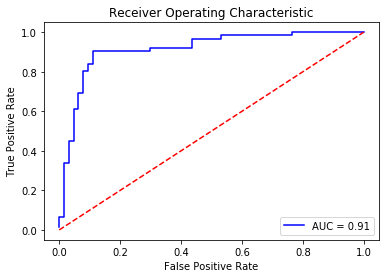

Sample predictions: 


,index,structureChainId,alpha,beta,coil,foldType,features,indexedLabel,predictions
0,2397,3CR3.A,0.729167,0.000000,0.270833,alpha,"[0.4506242929016733, 0.4021653594712469, -0.22...",0,alpha
1,5854,1DJ8.D,0.683544,0.025316,0.291139,alpha,"[0.45170262853868987, 0.27930005385794426, -0....",0,beta
2,1218,1GUI.A,0.045161,0.522581,0.432258,beta,"[0.45833617446992503, -0.08274550385797373, -0...",1,beta
3,1089,2FUL.B,0.660377,0.000000,0.339623,alpha,"[0.385830684279261, 0.5455603838517246, 0.0092...",0,alpha
4,8054,4U1F.A,0.035865,0.453586,0.510549,beta,"[0.35256124453453885, 0.3097596558302851, -0.0...",1,beta
5,6206,2B4H.B,0.018349,0.637615,0.344037,beta,"[0.6252799692302353, 0.4176309159165432, -0.21...",1,beta
6,2378,3CI3.A,0.569149,0.042553,0.388298,alpha,"[0.35667272570296893, 0.3017278991668567, -0.2...",0,alpha
7,3499,5FCG.C,0.615385,0.000000,0.384615,alpha,"[0.12529459595680237, 0.8606788708269596, 0.27...",0,beta
8,6804,4FZP.A,0.802469,0.000000,0.197531,alpha,"[0.25681320805516505, 0.536832901235256, 0.066...",0,alpha
9,4152,5UW8.B,0.000000,0.520408,0.479592,beta,"[0.795587436996462, 0.2920089698866133, -0.433...",1,beta


In [7]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
mcc = mltoolkit.MultiClassClassifier(clf, 'foldType', testFraction=0.1)
matrics = mcc.fit(df)
for k,v in matrics.items(): print(f"{k}\t{v}")
    
# Plot ROC 
mltoolkit.plot_roc(mcc.TPR, mcc.FPR, mcc.AUC)
    
print("Sample predictions: ")
mcc.prediction.head(10)

## Simple Multilayer Perception Classifier


 Class	Train	Test

alpha	559	67

beta	567	59

Total time taken: 1.1454405784606934

Methods	MLPClassifier
AUC	0.9488995699468757
F Score	0.864406779661017
Accuracy	0.873015873015873
Precision	0.864406779661017
Recall	0.864406779661017
False Positive Rate	0.13559322033898305
True Positive Rate	0.8805970149253731
	
Confusion Matrix
['alpha' 'beta']
[[59  8]
 [ 8 51]]


/home/marshuang80/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


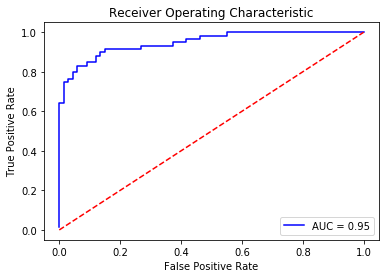

Sample predictions: 


,index,structureChainId,alpha,beta,coil,foldType,features,indexedLabel,predictions
0,2741,5WGG.B,0.000000,0.272727,0.727273,beta,"[0.34267553091049197, 0.6691838067024947, -0.0...",1,alpha
1,4382,4N5U.A,0.027778,0.509259,0.462963,beta,"[0.6066010274506848, 0.16251721533400745, -0.2...",1,beta
2,2442,5MUJ.A,0.048295,0.448864,0.502841,beta,"[0.30555264933868065, 0.19496887573776275, -0....",1,beta
3,1865,4W8Q.A,0.012821,0.534188,0.452991,beta,"[0.49341366341128884, 0.4072673920101459, -0.3...",1,beta
4,5532,2FOZ.A,0.663717,0.011799,0.324484,alpha,"[0.3460029140383952, 0.28717149838245326, -0.2...",0,alpha
5,1435,4NN5.A,0.651376,0.018349,0.330275,alpha,"[0.3948616978907308, 0.5869296146845517, -0.16...",0,beta
6,3543,2QFA.C,0.822222,0.000000,0.177778,alpha,"[0.1311187125418497, 0.7218705061418207, 0.002...",0,alpha
7,3532,2Q6Q.B,0.907692,0.000000,0.092308,alpha,"[0.42002009528956996, 0.9023373356369668, 0.04...",0,alpha
8,6090,2BWR.A,0.037406,0.376559,0.586035,beta,"[0.30329078999813647, 0.08428649192675948, -0....",1,beta
9,5227,3HNY.M,0.038462,0.519231,0.442308,beta,"[0.35430610996281986, 0.40682962074687207, -0....",1,beta


In [8]:
from sklearn.neural_network import MLPClassifier

layers = [featureCount, 32, 32, classCount]
clf = MLPClassifier(solver='sgd', \
                    alpha=1e-5, \
                    hidden_layer_sizes = (32, 32))
mcc = mltoolkit.MultiClassClassifier(clf, 'foldType', testFraction=0.1)

matrics = mcc.fit(df)
for k,v in matrics.items(): print(f"{k}\t{v}")
    
# Plot ROC 
mltoolkit.plot_roc(mcc.TPR, mcc.FPR, mcc.AUC)
    
print("Sample predictions: ")
mcc.prediction.head(10)

## Terminate Spark

In [9]:
spark.stop()